2026-02-19 18:07:50.469 | WARNING  | doroutes.pcells:<module>:25 - Cannot determine output type ((D)KCell type)from annotation <class 'kfactory.kcell.DKCell'>. Trying to continue but likely this will fail.
2026-02-19 18:07:50.472 | WARNING  | doroutes.pcells:<module>:48 - Cannot determine output type ((D)KCell type)from annotation <class 'kfactory.kcell.DKCell'>. Trying to continue but likely this will fail.
2026-02-19 18:07:50.472 | WARNING  | doroutes.pcells:<module>:110 - Cannot determine output type ((D)KCell type)from annotation <class 'kfactory.kcell.DKCell'>. Trying to continue but likely this will fail.
2026-02-19 18:07:50.473 | WARNING  | doroutes.pcells:<module>:149 - Cannot determine output type ((D)KCell type)from annotation <class 'kfactory.kcell.DKCell'>. Trying to continue but likely this will fail.
2026-02-19 18:07:50.476 | WARNING  | doroutes.pcells:<module>:168 - Cannot determine output type ((D)KCell type)from annotation <class 'kfactory.kcell.DKCell'>. Trying to con

/home/martin/Desktop/gsim/.venv/lib/python3.12/site-packages/gdsfactory/components/bends/bend_circular.py:86: UserWarning: {'width': 10.0} ignored for cross_section 'coplanar_waveguide'
  x = gf.get_cross_section(cross_section, width=width or x.width)


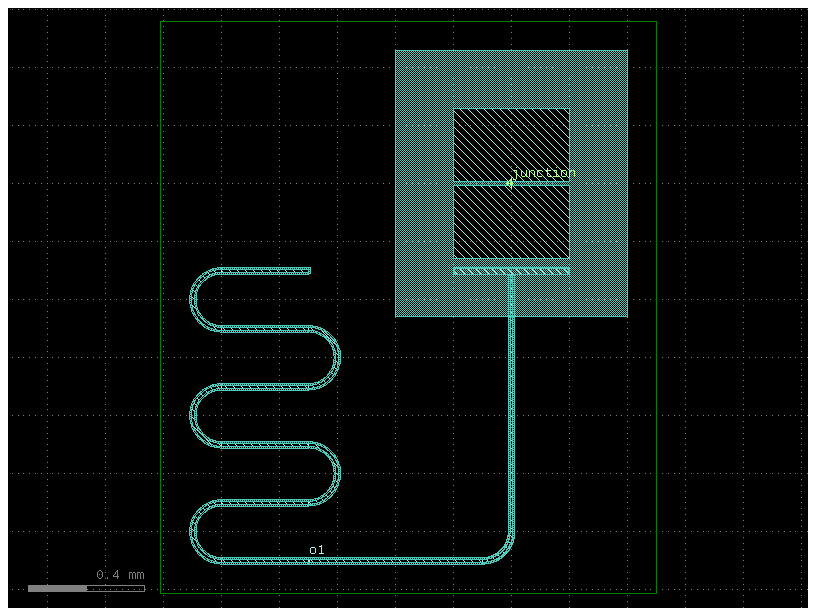

In [1]:
import gdsfactory as gf

from qpdk import PDK, cells
from qpdk.cells.helpers import apply_additive_metals
from qpdk.tech import LAYER

PDK.activate()


@gf.cell
def transmon_component() -> gf.Component:
    """Create a qubit with resonator layout."""
    c = gf.Component()

    ref = c << cells.qubit_with_resonator(
        qubit="double_pad_transmon_with_bbox",
        resonator_length=5000.0,
        resonator_meanders=5,
        qubit_rotation=90,
    )
    c.add_ports(ref.ports)

    # Add simulation area around the component
    c.kdb_cell.shapes(LAYER.SIM_AREA).insert(c.bbox().enlarged(100, 100))

    return c


component = transmon_component()
_c = component.copy()
_c.draw_ports()
_c

### Inspect raw layers and apply additive metals

In [2]:
from gsim.common.polygon_utils import inspect_layers

inspect_layers(component, filename="transmon_raw_layers.png")

# Apply additive metals processing (QPDK-specific step)
processed = apply_additive_metals(component.copy())
inspect_layers(processed, filename="transmon_processed_layers.png")

✓ Layer plot saved to transmon_raw_layers.png
✓ Layer plot saved to transmon_processed_layers.png


### Convert QPDK etch layers to conductor geometry

✓ Layer plot saved to transmon_etched_layers.png


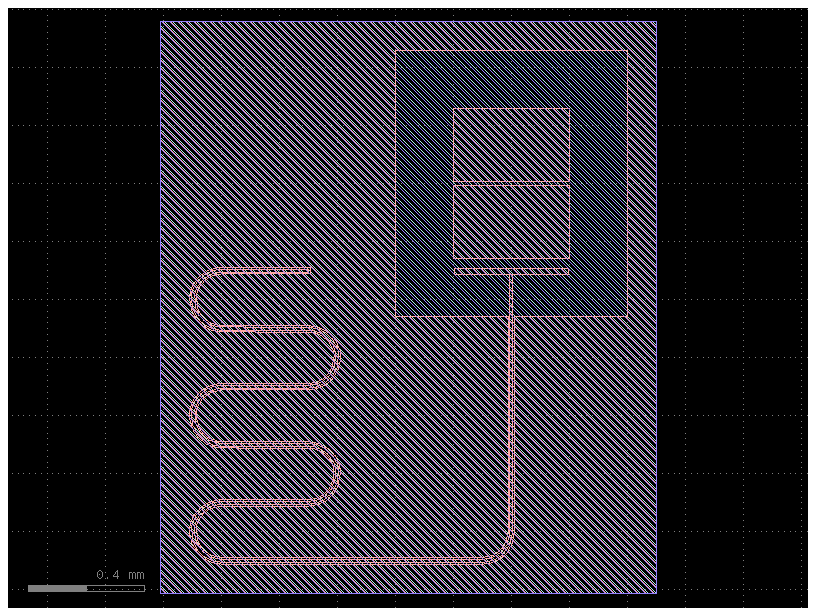

In [3]:
from gsim.common.qpdk import create_etched_component
from gsim.common.rf_layers import cpw_layer_stack

layer_stack, CPW_LAYER = cpw_layer_stack(
    substrate_thickness=500, vacuum_thickness=500
)

etched = create_etched_component(component=processed, cpw_layers=CPW_LAYER)

inspect_layers(etched, filename="transmon_etched_layers.png")
etched

### Configure eigenmode simulation

The junction port is modelled as a lumped element with a 10 nH inductance.

In [ ]:
from gsim.palace import EigenmodeSim

sim = EigenmodeSim()
sim.set_geometry(etched)
sim.set_stack(substrate_thickness=500, air_above=500)

# Junction port with 10 nH inductance
sim.add_port("junction", layer="CONDUCTOR", length=5.0, inductance=10e-9)

# CPW feed ports
sim.add_cpw_port("o1", layer="CONDUCTOR", length=5.0)

sim.set_eigenmode(target=5e9, num_modes=3)

TypeError: EigenmodeSim.add_cpw_port() missing 1 required positional argument: 'lower'

### Mesh and run

In [5]:
sim.set_output_dir("./sim_qpdk_qubit_resonator")
sim.mesh(preset="coarse")
sim.plot_mesh()

Could not parse layer (SIM_AREA - (M1_ETCH - M1_DRAW))


ValueError: CPW lower port 'o2' not found.

In [ ]:
results = sim.run()

if results.ok:
    print("Eigenvalues")
    print(f"{'Freq (GHz)':<16} {'Q':<16}")
    for ev in results.eigenvalues:
        print(f"{ev.freq:<16.4f} {ev.quality_factor:<16.4f}")
else:
    print("Simulation failed:", results.error_msg)